# ETL concepts and pipeline

In this experiment you:

* use Spark’s built-in and external data sources to read, refine, and write data in different file formats as part of the extract, transform, and load (ETL) tasks
* perform complex data exploration and analysis using Spark SQL

### Introduction

ETL (Extract, Transform, and Load) is the procedure of migrating data from one system to another.
* Data **extraction** is the process of retrieving data out of homogeneous or heterogeneous sources for further data processing and data storage.
* During data **transformation**, the data is cleaned and incorrect or inaccurate records are modified or deleted.
* Finally, the processed data is **loaded** (or stored) into a target system such as a data warehouse or NoSQL database or RDBMS.

Data engineers use Spark because it provides a simple way to parallelize computations and hides all the complexity of distribution and fault tolerance. This leaves them free to focus on using high-level DataFrame-based APIs and domain-specific language queries to do ETL, reading and combining data from multiple sources.

Here we will consider tabular data to do ETL operations. Starting from data extraction, we will perform various transformations and try to gain some insights from it and then load it to a NoSQL database or store it in different file formats.

### Dataset

The dataset chosen for this assignment is [Productivity Prediction of Garment Employees](https://archive.ics.uci.edu/ml/datasets/Productivity+Prediction+of+Garment+Employees). The dataset is made up of 1197 records and 15 columns. It includes important attributes of the garment manufacturing process and the productivity of the employees. The dataset contains records of three months (Jan to Mar 2015) with 2 distinct departments, 12 unique team numbers and 5 different quarters. Some of the features are listed below:

* date: Date in MM-DD-YYYY
* day: Day of the Week
* quarter: A portion of the month. A month was divided into four quarters
* department: Associated department with the instance
* team: Associated team number with the instance
* no_of_workers: Number of workers in each team
* no_of_style_change: Number of changes in the style of a particular product
* targeted_productivity: Targeted productivity set by the Authority for each team for each day.
* smv: Standard Minute Value, it is the allocated time for a task
* wip: Work in progress. Includes the number of unfinished items for products
* overtime: Represents the amount of overtime by each team in minutes
* incentive: Represents the amount of financial incentive (in BDT) that enables or motivates a particular course of action.
* idletime: The amount of time when the production was interrupted due to several reasons
* idlemen: The number of workers who were idle due to production interruption
* actual_productivity: The actual % of productivity that was delivered by the workers. It ranges from 0-1.

Date, quarter, department, and day are object datatypes and the rest are int or float types.

To know more about the dataset click [here](https://archive.ics.uci.edu/ml/datasets/Productivity+Prediction+of+Garment+Employees).

### Install Pyspark

In [ ]:
#!pip install pyspark

### Import required packages

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MinMaxScaler
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd

### Start a Spark Session

Spark session is a combined entry point of a Spark application, which came into implementation from Spark 2.0. Instead of having various context, everything is now encapsulated in a **Spark session**.

In [2]:
# Start spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('ETL').getOrCreate()
spark

### Tabular Data Analytics

#### Extract data into PySpark
To load the dataset we will use the read.csv module.  The inferSchema parameter provided will enable Spark to automatically determine the data type for each column.

In [3]:
df = spark.read.csv('garments_worker_productivity.csv', header=True, inferSchema= True)

#### Transforming Data

* Display first few rows of the data

In [5]:
df.limit(10).toPandas()

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,1/1/2015,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,1/1/2015,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
2,1/1/2015,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,1/1/2015,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,1/1/2015,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382
5,1/1/2015,Quarter1,sweing,Thursday,7,0.80,25.90,984.0,6720,38,0.0,0,0,56.0,0.800125
6,1/1/2015,Quarter1,finishing,Thursday,2,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.755167
7,1/1/2015,Quarter1,sweing,Thursday,3,0.75,28.08,795.0,6900,45,0.0,0,0,57.5,0.753683
8,1/1/2015,Quarter1,sweing,Thursday,2,0.75,19.87,733.0,6000,34,0.0,0,0,55.0,0.753098
9,1/1/2015,Quarter1,sweing,Thursday,1,0.75,28.08,681.0,6900,45,0.0,0,0,57.5,0.750428


In the above output, the wip (work in progress) column contains null values. We need to check for other columns as well.
* Display total number of rows

In [6]:
df.count()

1197

* Check for Null values in each column

In [8]:
df.select([(count(when(isnan(c) | col(c).isNull(), c))/1197).alias(c) for c in df.columns]).toPandas()

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.422723,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The wip column contains around 42% null values so we can drop that column.
* Drop the wip column having Null values

In [9]:
df1 = df.drop('wip')

In [10]:
# Recheck for null values
df1.select([(count(when(isnan(c) | col(c).isNull(), c))/1197).alias(c) for c in df1.columns]).toPandas()

,date,quarter,department,day,team,targeted_productivity,smv,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Let's see the distinct values in department column.
* Display distinct `department` from dataframe

In [11]:
# Display count of distinct 'department'
df1.select('department').distinct().count()

3

In [12]:
# Display distinct values for 'department' column
df1.select('department').distinct().show()

+----------+
|department|
+----------+
|    sweing|
| finishing|
|finishing |
+----------+



There is ambiguity in distinct department values and it needs to be taken care of.
* Transform department column

In [13]:
# Removing trailing spaces from both sides using department column
df2 = df1.withColumn('department', trim(col('department')))

In [14]:
# Display distinct values for 'department' column
df2.select('department').distinct().show()

+----------+
|department|
+----------+
|    sweing|
| finishing|
+----------+



In [15]:
# Replacing department value from 'sweing' to 'sewing' 
df3 = df2.withColumn('department', regexp_replace(col('department'), 'sweing', 'sewing'))

In [16]:
# Display distinct values for 'department' column
df3.select('department').distinct().show()

+----------+
|department|
+----------+
|    sewing|
| finishing|
+----------+



Similar to the distinct department values, our data might contain duplicate values as well.
* Check for duplicate values in data

In [17]:
cols = df3.columns
if df3.count() > df3.dropDuplicates(cols).count():
    print('Data has duplicates')
else:
  print('Data has no duplicates')

Data has no duplicates


If data has duplicate values, run the below cell by uncommenting it

In [18]:
# df3 = df3.dropDuplicates(df3.columns)

After removing duplicates, let's take a look at the datatypes of our columns.
* Display data types of dataframe columns

In [19]:
# Print the data types 
df3.dtypes

[('date', 'string'),
 ('quarter', 'string'),
 ('department', 'string'),
 ('day', 'string'),
 ('team', 'int'),
 ('targeted_productivity', 'double'),
 ('smv', 'double'),
 ('over_time', 'int'),
 ('incentive', 'int'),
 ('idle_time', 'double'),
 ('idle_men', 'int'),
 ('no_of_style_change', 'int'),
 ('no_of_workers', 'double'),
 ('actual_productivity', 'double')]

Here, the 'date' column has a string datatype. In order to perform analytics involving year and month, we need to convert it into timestamp datatype. 
* Transform the `date` column from string type to Spark `timestamp` data type

In [20]:
df4 = df3.withColumn("date", to_timestamp(col("date"), "M/d/yyyy"))

In [21]:
df4.dtypes

[('date', 'timestamp'),
 ('quarter', 'string'),
 ('department', 'string'),
 ('day', 'string'),
 ('team', 'int'),
 ('targeted_productivity', 'double'),
 ('smv', 'double'),
 ('over_time', 'int'),
 ('incentive', 'int'),
 ('idle_time', 'double'),
 ('idle_men', 'int'),
 ('no_of_style_change', 'int'),
 ('no_of_workers', 'double'),
 ('actual_productivity', 'double')]

Now we can use the `year()` SQL Spark function on the Timestamp column data type `date`.
* Display how many distinct years of data is in the dataset

In [22]:
df4.select(year('date')).distinct().orderBy(year('date')).show()

+----------+
|year(date)|
+----------+
|      2015|
+----------+



We see that all the records are from the year 2015.

Similar to year() we can use the `month()` SQL Spark function on the Timestamp datatype column `date`.
* Display how many distinct months of data is in the dataset

In [23]:
df4.select(month('date')).distinct().orderBy(month('date')).show()

+-----------+
|month(date)|
+-----------+
|          1|
|          2|
|          3|
+-----------+



We see that the data was collected in the months January to March.

* Check in which month the productivity was maximum

+-----------+------------------------+
|month(date)|avg(actual_productivity)|
+-----------+------------------------+
|          1|      0.7554150713210328|
|          3|      0.7189527641273588|
|          2|      0.7179482808871328|
+-----------+------------------------+



<AxesSubplot:xlabel='month(date)', ylabel='avg(actual_productivity)'>

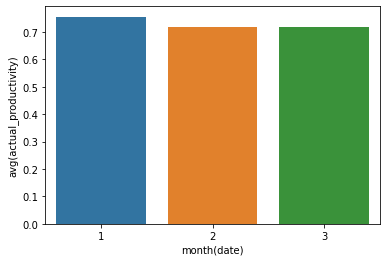

In [24]:
df_d = df4.groupby(month('date')).avg().select(['month(date)', 'avg(actual_productivity)'])
df_d.show()
sns.barplot(x = df_d.toPandas()['month(date)'], y= df_d.toPandas()['avg(actual_productivity)'])

From the above plot, it can be seen that in January the productivity was little higher than remaining two.

Let's gain few more insights from the data
* Display the incentives paid to different teams

+----+------------------+
|team|    avg(incentive)|
+----+------------------+
|  12|  41.2020202020202|
|   1|              46.6|
|   6| 22.70212765957447|
|   3| 49.55789473684211|
|   5| 49.13978494623656|
|   9| 60.93269230769231|
|   4| 35.04761904761905|
|   8|24.880733944954127|
|   7|          15.53125|
|  10|             36.33|
|  11| 37.90909090909091|
|   2|38.211009174311926|
+----+------------------+



<AxesSubplot:xlabel='team', ylabel='avg(incentive)'>

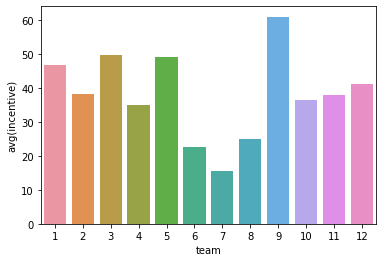

In [25]:
df_i = df4.groupby('team').avg().select(['team', 'avg(incentive)'])
df_i.show()
sns.barplot(x = df_i.toPandas()['team'], y= df_i.toPandas()['avg(incentive)'])

So on average team 9 received the highest incentive.
* Display number of workers in each Team

+----+------------------+
|team|sum(no_of_workers)|
+----+------------------+
|  12|            2368.0|
|   1|            3679.5|
|   6|            2366.0|
|   3|            3754.5|
|   5|            3662.5|
|   9|            3662.0|
|   4|            4011.0|
|   8|            3650.5|
|   7|            3561.5|
|  10|            3529.5|
|  11|            3409.0|
|   2|            3774.0|
+----+------------------+



<AxesSubplot:xlabel='team', ylabel='sum(no_of_workers)'>

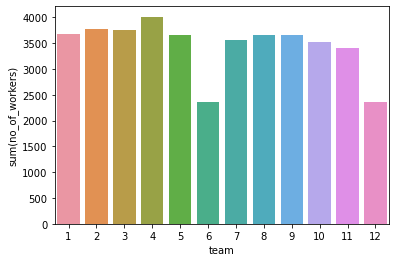

In [27]:
df_w = df4.groupby('team').sum().select(['team', 'sum(no_of_workers)'])
df_w.show()
sns.barplot(x = df_w.toPandas()['team'], y= df_w.toPandas()['sum(no_of_workers)'])

From the above plot, it can be seen that team 6 and 12 have less number of workers compared to other teams.

Let's find out how much it costs for the first quarter of the first month.
* Display the `incentive` paid for the first quarter of the first month

In [28]:
df_q = df4.select(month("date"), "quarter", "incentive").where((col('month(date)') == 1) & (col("quarter") == "Quarter1"))
df_q.show(5)
df_q.groupby('quarter').sum().select('sum(incentive)').show()

+-----------+--------+---------+
|month(date)| quarter|incentive|
+-----------+--------+---------+
|          1|Quarter1|       98|
|          1|Quarter1|        0|
|          1|Quarter1|       50|
|          1|Quarter1|       50|
|          1|Quarter1|       50|
+-----------+--------+---------+
only showing top 5 rows

+--------------+
|sum(incentive)|
+--------------+
|          3525|
+--------------+



Before fitting to a model, the outlier removal and feature scaling of data are important.
* Check for outliers

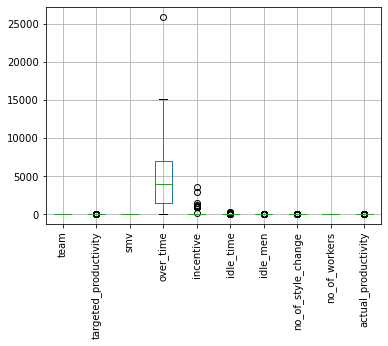

In [29]:
df4.toPandas().boxplot()
plt.xticks(rotation= 90)
plt.show()

* Handling outliers

Here instead of removing the outliers we will change their values to upper bound and lower bound depending on whether the value is higher than upper bound or lower than lower bound respectively.

In [38]:
df5 = df4
outlier_cols = ["targeted_productivity", "smv", "over_time", "incentive", "idle_time", "idle_men", "no_of_style_change", "actual_productivity"] # Columns with outliers
def handle_outliers(df, colm):
    df = df.toPandas()
    q1 = df.describe()[colm].loc["25%"]
    q3 = df.describe()[colm].loc["75%"]
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    for i in range(len(df)):
      if df.loc[i,colm] > upper_bound:
        df.loc[i,colm]= upper_bound
      if df.loc[i,colm] < lower_bound:
        df.loc[i,colm]= lower_bound
    return spark.createDataFrame(df)
    
for colm in outlier_cols:
    df5 = handle_outliers(df5, colm)

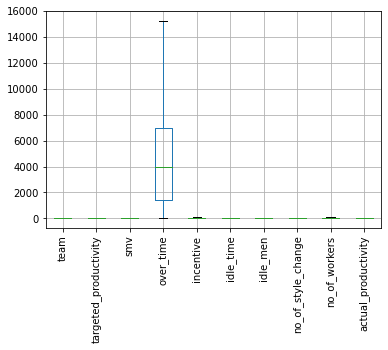

In [31]:
# Recheck for outliers
df5.toPandas().boxplot()
plt.xticks(rotation= 90)
plt.show()

* Scaling features

In [32]:
# Display the statistics of dataframe
df5.toPandas().describe()

,team,targeted_productivity,smv,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
count,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.0,1197.0,1197.0,1197.000000,1197.000000
mean,6.426901,0.736842,15.062172,4558.538012,26.712615,0.0,0.0,0.0,34.609858,0.737397
std,3.463963,0.075515,10.943219,3305.837733,31.563351,0.0,0.0,0.0,22.197687,0.168772
min,1.000000,0.550000,2.900000,0.000000,0.000000,0.0,0.0,0.0,2.000000,0.350389
25%,3.000000,0.700000,3.940000,1440.000000,0.000000,0.0,0.0,0.0,9.000000,0.650307
50%,6.000000,0.750000,15.260000,3960.000000,0.000000,0.0,0.0,0.0,34.000000,0.773333
75%,9.000000,0.800000,24.260000,6960.000000,50.000000,0.0,0.0,0.0,57.000000,0.850253
max,12.000000,0.800000,54.560000,15240.000000,125.000000,0.0,0.0,0.0,89.000000,1.120437


In [34]:
# Specify columns that need to be scaled
columns = ["smv", "over_time", "incentive", "no_of_workers"]

In [39]:
df5.limit(5).toPandas()

,date,quarter,department,day,team,targeted_productivity,smv,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,2015-01-01,Quarter1,sewing,Thursday,8,0.80,26.16,7080,98,0.0,0,0,59.0,0.940725
1,2015-01-01,Quarter1,finishing,Thursday,1,0.75,3.94,960,0,0.0,0,0,8.0,0.886500
2,2015-01-01,Quarter1,sewing,Thursday,11,0.80,11.41,3660,50,0.0,0,0,30.5,0.800570
3,2015-01-01,Quarter1,sewing,Thursday,12,0.80,11.41,3660,50,0.0,0,0,30.5,0.800570
4,2015-01-01,Quarter1,sewing,Thursday,6,0.80,25.90,1920,50,0.0,0,0,56.0,0.800382


In [36]:
print("Before Scaling :")
df5.limit(5).toPandas()
df6 = df5

from pyspark.ml.feature import MinMaxScaler, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import udf, round
from pyspark.sql.types import DoubleType

# UDF for converting column type from vector to double type
unlist = udf(lambda x: float(list(x)[0]), DoubleType())
spark.udf.register("unlist", unlist)

# Iterating over columns to be scaled
for i in columns:
    # VectorAssembler Transformation - Converting column to vector type
    assembler = VectorAssembler(inputCols=[i],outputCol=i+"_Vect")

    # MinMaxScaler Transformation
    scaler = MinMaxScaler(inputCol=i+"_Vect", outputCol=i+"_Scaled")

    # Pipeline of VectorAssembler and MinMaxScaler
    pipeline = Pipeline(stages=[assembler, scaler])

    # Fitting pipeline on dataframe
    df6 = pipeline.fit(df6).transform(df6).withColumn(i+"_Scaled", unlist(i+"_Scaled")).drop(i+"_Vect")

print("After Scaling :")
df6.limit(5).toPandas()

Before Scaling :
After Scaling :


,date,quarter,department,day,team,targeted_productivity,smv,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,smv_Scaled,over_time_Scaled,incentive_Scaled,no_of_workers_Scaled
0,2015-01-01,Quarter1,sewing,Thursday,8,0.80,26.16,7080,98,0.0,0,0,59.0,0.940725,0.450252,0.464567,0.784,0.655172
1,2015-01-01,Quarter1,finishing,Thursday,1,0.75,3.94,960,0,0.0,0,0,8.0,0.886500,0.020132,0.062992,0.000,0.068966
2,2015-01-01,Quarter1,sewing,Thursday,11,0.80,11.41,3660,50,0.0,0,0,30.5,0.800570,0.164731,0.240157,0.400,0.327586
3,2015-01-01,Quarter1,sewing,Thursday,12,0.80,11.41,3660,50,0.0,0,0,30.5,0.800570,0.164731,0.240157,0.400,0.327586
4,2015-01-01,Quarter1,sewing,Thursday,6,0.80,25.90,1920,50,0.0,0,0,56.0,0.800382,0.445219,0.125984,0.400,0.620690


After outlier removal, few records got deleted. Let's create a new `id` column that will contain a unique value for each record.

In [40]:
df7 = df6.withColumn("id", monotonically_increasing_id()+1)
df7.select('id').show(5)

+---+
| id|
+---+
|  1|
|  2|
|  3|
|  4|
|  5|
+---+
only showing top 5 rows



We can also perform SQL queries on spark dataframe using the `spark.sql()` function. But for that, we first need to register the dataframe as a table in the spark catalog. We can do this using the `createOrReplaceTempView()` spark dataframe method. It takes the name of the temporary table we'd like to register as argument. As this table is temporary, it can only be accessed from the specific SparkSession used to create the Spark dataframe. 

In [41]:
df7.createOrReplaceTempView('df_table')
spark.sql("select date, department, team, smv, over_time, incentive from df_table where department='sewing'").show(5)

+-------------------+----------+----+-----+---------+---------+
|               date|department|team|  smv|over_time|incentive|
+-------------------+----------+----+-----+---------+---------+
|2015-01-01 00:00:00|    sewing|   8|26.16|     7080|       98|
|2015-01-01 00:00:00|    sewing|  11|11.41|     3660|       50|
|2015-01-01 00:00:00|    sewing|  12|11.41|     3660|       50|
|2015-01-01 00:00:00|    sewing|   6| 25.9|     1920|       50|
|2015-01-01 00:00:00|    sewing|   7| 25.9|     6720|       38|
+-------------------+----------+----+-----+---------+---------+
only showing top 5 rows



#### Load Data

Once we have extracted and transformed our data, we might want to load it into the destination or store it somewhere. We will load it into the MongoDB database.

Data in MongoDB is represented and stored using JSON-style documents. In PyMongo we use dictionaries to represent documents.

In [42]:
data = df7.toPandas()
documents = []
for i in range(len(data)):
        doc = data.iloc[i,:].to_dict()
        for keys in doc:
          if keys != 'date':
            if type(doc[keys]) not in [str]:
                doc[keys] = float(doc[keys])
        documents.append(doc)
documents[0:1]

[{'date': Timestamp('2015-01-01 00:00:00'),
  'quarter': 'Quarter1',
  'department': 'sewing',
  'day': 'Thursday',
  'team': 8.0,
  'targeted_productivity': 0.8,
  'smv': 26.16,
  'over_time': 7080.0,
  'incentive': 98.0,
  'idle_time': 0.0,
  'idle_men': 0.0,
  'no_of_style_change': 0.0,
  'no_of_workers': 59.0,
  'actual_productivity': 0.940725424,
  'smv_Scaled': 0.4502516453735966,
  'over_time_Scaled': 0.4645669291338583,
  'incentive_Scaled': 0.784,
  'no_of_workers_Scaled': 0.6551724137931034,
  'id': 1.0}]

If you would like to perform the data insertion step then please **create your own account** on MongoDB Atlas as given in the reference [here](https://cdn.iisc.talentsprint.com/CDS/DB_Connect_Docs/Assignment_MongoDB_Connect.pdf) and change the credentials and run the below code by uncommenting it.

In [ ]:
### new_document = coll.insert_many(documents)

Also, we can store the data in other formats like json, csv, and parquet and read it back whenever required.

**Store the dataframe as a `json file`**

In [43]:
df7.write.format("json").mode("overwrite").save('transformed_json_data.json')

**Read data from `json` to spark dataframe**

In [44]:
df_json = spark.read.format("json").load('transformed_json_data.json')

In [45]:
df_json.limit(20).toPandas()

,actual_productivity,date,day,department,id,idle_men,idle_time,incentive,incentive_Scaled,no_of_style_change,no_of_workers,no_of_workers_Scaled,over_time,over_time_Scaled,quarter,smv,smv_Scaled,targeted_productivity,team
0,0.463194,2015-03-03T00:00:00.000+05:30,Tuesday,finishing,60129542145,0,0.0,0,0.000,0,8.0,0.068966,3360,0.220472,Quarter1,2.90,0.000000,0.70,10
1,0.354444,2015-03-03T00:00:00.000+05:30,Tuesday,finishing,60129542146,0,0.0,0,0.000,0,8.0,0.068966,3360,0.220472,Quarter1,4.60,0.032907,0.70,5
2,0.350389,2015-03-03T00:00:00.000+05:30,Tuesday,finishing,60129542147,0,0.0,0,0.000,0,8.0,0.068966,3360,0.220472,Quarter1,2.90,0.000000,0.75,6
3,0.350389,2015-03-03T00:00:00.000+05:30,Tuesday,sewing,60129542148,0,0.0,0,0.000,0,45.0,0.494253,5400,0.354331,Quarter1,15.28,0.239644,0.55,2
4,0.939167,2015-03-04T00:00:00.000+05:30,Wednesday,finishing,60129542149,0,0.0,0,0.000,0,10.0,0.091954,1200,0.078740,Quarter1,4.60,0.032907,0.80,3
5,0.930417,2015-03-04T00:00:00.000+05:30,Wednesday,finishing,60129542150,0,0.0,0,0.000,0,8.0,0.068966,960,0.062992,Quarter1,4.60,0.032907,0.80,8
6,0.885926,2015-03-04T00:00:00.000+05:30,Wednesday,finishing,60129542151,0,0.0,0,0.000,0,9.0,0.080460,1080,0.070866,Quarter1,4.60,0.032907,0.80,12
7,0.833750,2015-03-04T00:00:00.000+05:30,Wednesday,finishing,60129542152,0,0.0,0,0.000,0,8.0,0.068966,960,0.062992,Quarter1,2.90,0.000000,0.75,9
8,0.806879,2015-03-04T00:00:00.000+05:30,Wednesday,finishing,60129542153,0,0.0,0,0.000,0,8.0,0.068966,960,0.062992,Quarter1,3.94,0.020132,0.70,1
9,0.806058,2015-03-04T00:00:00.000+05:30,Wednesday,finishing,60129542154,0,0.0,0,0.000,0,8.0,0.068966,960,0.062992,Quarter1,3.94,0.020132,0.70,4


**Store the dataframe as a `csv file`**

In [46]:
df7.write.format("csv").mode("overwrite").option("header", "true").save("transformed_csv_data.csv")

**Read data from `csv` to spark dataframe**

In [47]:
df_csv = spark.read.format("csv").option("header", "true").load('transformed_csv_data.csv')

In [48]:
df_csv.show(5)

+--------------------+--------+----------+---------+----+---------------------+-----+---------+---------+---------+--------+------------------+-------------+-------------------+-------------------+-------------------+----------------+--------------------+-----------+
|                date| quarter|department|      day|team|targeted_productivity|  smv|over_time|incentive|idle_time|idle_men|no_of_style_change|no_of_workers|actual_productivity|         smv_Scaled|   over_time_Scaled|incentive_Scaled|no_of_workers_Scaled|         id|
+--------------------+--------+----------+---------+----+---------------------+-----+---------+---------+---------+--------+------------------+-------------+-------------------+-------------------+-------------------+----------------+--------------------+-----------+
|2015-03-03T00:00:...|Quarter1| finishing|  Tuesday|  10|                  0.7|  2.9|     3360|        0|      0.0|       0|                 0|          8.0|        0.463194444|                0.0

**Use Parquet files to store data**

Parquet uses snappy compression to compress the data. If the DataFrame is written as Parquet, the schema is preserved as part of the Parquet metadata.

To know more about parquet file format click [here](https://www.ellicium.com/parquet-file-format-structure/).

In [49]:
df7.write.format("parquet").mode("overwrite").save("transformed_parquet_data")

**Read data from Parquet file**

We don't have to specify the schema here since it's stored as part of the Parquet metadata.

In [50]:
df_parquet = spark.read.format("parquet").load("transformed_parquet_data")

In [51]:
df_parquet.show(5)

+-------------------+--------+----------+--------+----+---------------------+-----+---------+---------+---------+--------+------------------+-------------+-------------------+-------------------+-------------------+----------------+--------------------+-----------+
|               date| quarter|department|     day|team|targeted_productivity|  smv|over_time|incentive|idle_time|idle_men|no_of_style_change|no_of_workers|actual_productivity|         smv_Scaled|   over_time_Scaled|incentive_Scaled|no_of_workers_Scaled|         id|
+-------------------+--------+----------+--------+----+---------------------+-----+---------+---------+---------+--------+------------------+-------------+-------------------+-------------------+-------------------+----------------+--------------------+-----------+
|2015-01-17 00:00:00|Quarter3| finishing|Saturday|  11|                  0.8| 4.15|     1260|        0|      0.0|       0|                 0|          7.0|         0.35038907|0.02419667053813396|0.08267